### Chord detection using pitch class profiles and Essentia algorithms on The Beatles studio discography
##### Music Information Retrieval Course Project, Winter 2019
#### Written by Linda Bedrani

Using the Beatles discography dataset, this notebook will perform a chord detection algorithm using low-level feature extraction from Essentia, and Essentia's ChordsDetection algorithm. The results will be evaluated by comparing to the chord annotations provided on the Isophonics website, which have been tried and true by the MIR community. These annotations are provided in the following format: 

Chris Harte's doctoral dissertation on automatic extraction of harmony information using this same Beatles dataset described the following methodology for frame-based chord recognition: 

• Use of a tuning algorithm to generate a quantised chromagram.
• Generating the tonal centroid based on the 6D pitch class hypertorus.
• Development of the harmonic change detection function (HCDF)
from the tonal centroid.
• Use of peak picked HCDF for chord recognition segmentation.
• Improved peak picking of HCDF for better chord segmentation.

This is illustrated in the block diagram below, taken from this paper:

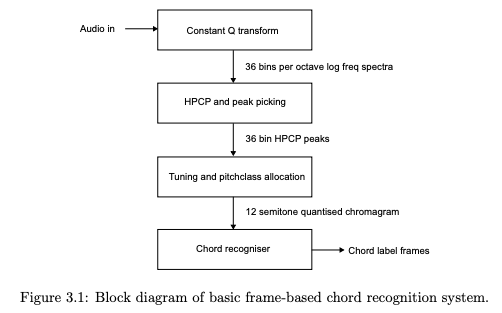

Beatles dataset: Provided by author, not included due to copyright rules. The dataset consists of 12 studio albums by the Beatles:

Please Please Me, With The Beatles, A Hard Day's Night, Beatles For Sale, Help!, Rubber Soul, Revolver, Sgt. Pepper's Lonely Hearts Club Band, Magical Mystery Tour, The Beatles (CD1 and 2), Abbey Road, and Let It Be.

Beatles dataset annotations: http://www.isophonics.net/content/reference-annotations-beatles 

#### Useful references: 
2017 MIREX09: https://www.music-ir.org/mirex/wiki/2017:Audio_Chord_Estimation 
Harte, C. (2010). Towards automatic extraction of harmony information from music signals (Doctoral dissertation). 

In [36]:
# Import modules for csv manipulation
import csv
import pandas as pd

# Import modules
import os
import numpy as np

# Import Essentia
import essentia.standard as ess
import essentia.streaming as esstr
import essentia
from essentia.standard import *
from essentia.standard import *
#import essentia_chord_utils


# Import plotting modules
from pylab import plot, show, figure, imshow
import matplotlib.pyplot as plt

### Segment the audio into beats and compute the pitch class profiles

This is necessary in order to use the ChordsDetectionBeats algorithm later on.

In [101]:
# Load segment annotations from the annotated datasets

def loadAnnotatedSegmentsFromLab(file):

    '''Loads segments annotations from .lab file
    Parameters
    ----------
    file : str
        Audio file name
        
    Returns
    -------
    segments : AnnotatedSegments
    '''
    
    labels = []
    startTimes = []
    durations = []
    folder = './The_Beatles_Annotations/chord lab/The Beatles/01_Please_Please_Me'
    
    #for file in folder:    
    with open(file) as f:
        for line in f:
            start, end, label = line.strip().split(" ")
            labels.append(label)
            startTimes.append(float(start))
            durations.append(float(end) - float(start))
    return np.array(labels, dtype='object'), np.array(startTimes, dtype='float'), np.array(durations, dtype='float')

In [78]:
# The following functions will smooth out the chroma features 
# zeroLowEnergy will set all low-energy frames to zero to reduce noise
# smoothChroma will convolve the chroma sequences 

def zeroLowEnergy(chroma, spectra):
    '''
    Borrowed from Lecture4_step2_ChordDetectionDemo
    Set chromas for low energy frames to zero.
    Parameters
    ----------
    chroma : numpy.array(dtype=float)
        chroma data (Nx12)
    spectra : numpy.array(dtype=float)
        audio data
    Returns
    -------
    chroma: numpy.array
    '''
    NRG=np.sum(np.power(spectra,2), axis=1)
    chroma[NRG<np.max(NRG)*NRG_CUTOFF_COEFFICIENT] = np.zeros(12)
    return chroma

def smoothChroma(chroma, hopSize = 4096, fs = 44100):
    '''
    Borrowed from Lecture4_step2_ChordDetectionDemo
    Smooth chroma features by convolving each of 12 chroma sequences with hanning window.
    '''
    return smooth(chroma, window_len=int(SMOOTHING_TIME * fs / hopSize), window='hanning').astype(
                         'float32')

In [115]:
def loadChromaAndSpectrum(filename, frameSize, tuningFreq=440, hopSize = 4096):
    '''
    Extract HPCP chroma features with essentia
    Parameters
    ----------
    filename: str
        audio file name
    frameSize : int
        Analysis frame size (samples)
    tuningFreq : float
        tuning frequency (Hz)
    hopSize : int
        Hop size (in samples)
    Returns
    -------
    chroma: numpy.array
    spectra: numpy.array
    '''
    loader = esstr.MonoLoader(filename = filename)
    beats, _ = BeatTrackerMultiFeature(loader)
    framecutter = esstr.FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = esstr.Windowing(type="blackmanharris62")
    spectrum = esstr.Spectrum()
    spectralpeaks = esstr.SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    hpcp = esstr.HPCP(
        size=12,
        referenceFrequency = tuningFreq,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitSum')
    
    
    chords = ChordsDetection(hpcp)
    chordbeats = ChordsDetectionBeats(hpcp, beats)
    
    #pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    loader.audio >> beats.beat
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectrum.spectrum >> (pool, 'spectrum.magnitude')
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    #hpcp.hpcp >> (pool, 'chroma.hpcp')
    hpcp.magnitudes >> chords.detection
    hpcp.magnitudes >> chordsbeats.detection
    beats.beat >> chordbeats.detection

    essentia.run(loader)
    #chroma = pool['chroma.hpcp']
    #spectra = pool['spectrum.magnitude']
    
    # Set the energy for low-energy frames to zero and smooth the chroma features
    chroma = zeroLowEnergy(chroma, spectra)
    chroma = smoothChroma(chroma)
    
    #chroma = np.array(chroma, dtype=float)
    #spectra = np.array(spectra, dtype=float)
    
    return chroma, spectra, chords, chordsbeats



In [117]:
soundsDIR = '../audio/'
labsDIR = '../labs/'
sound_file ='02_Misery.mp3'
lab_file = '02_-_Misery.lab' 

# The Essentia ChordsDetection algorithm assumes that the HPCPs have been calculed with framesize = 2*hopsize, 
# Hop size was set to 4096, so the frame size should be set to 8192

frame_size = 8192

#start, dur, chords = loadAnnotatedSegmentsFromLab(labsDIR+lab_file)
#print(chords)

chroma, spectra = loadChromaAndSpectrum(soundsDIR+sound_file, frame_size)

# Calculate the beat positions to pass to the ChordDetectionBeats function


TypeError: __init__() takes 1 positional argument but 2 were given

In [99]:
print(beat)

[   0.42956915    0.85913831    1.30031741    1.75310659    2.21750569
    2.67029476    3.05342388    3.43655324    3.83129239    4.20281172
    4.52789116    4.87619019    5.21287966    5.58439922    6.03718805
    6.50158739    6.95437622    7.40716553    7.87156439    8.33596325
    8.81197262    9.26476192    9.72916126   10.17033958   10.63473892
   11.0759182    11.54031754   11.98149681   12.42267513   12.86385441
   13.32825375   13.76943302   14.2106123    14.65179157   15.11618996
   15.56897926   16.01015854   16.46294785   16.90412712   17.3453064
   17.78648567   18.23927498   18.69206238   19.14485168   19.58603096
   20.03882027   20.46838951   20.93278885   21.36235809   21.80353737
   22.24471664   22.70911598   23.15029526   23.59147263   24.05587196
   24.50866127   24.96145058   25.40262985   25.84380913   26.29659843
   26.74938774   27.20217705   27.65496635   28.09614372   28.537323
   29.00172234   29.44290161   29.88408089   30.32526016   30.7896595
   31.2308

In [85]:
chords = ess.ChordsDetectionBeats()
estimated_chords = chords(chroma, beats)

TypeError: essentia can currently only accept two-dimensional numpy arrays of dtype "single"

### Use Essentia ChordsDetection algorithm on the pitch class profiles

### Save the results as a csv file

### Compare results with chord annotations

### Discussion of results